# ДЗ 1
## Классический МЛ в NLP, вспомнить все!

В этом ДЗ будем работать с датасетом Men_Women_Shoes_Reviews https://www.kaggle.com/daishinkan002/men-women-shoes-reviews 
 

### **Задание 1**. 
Предсказать цену по описанию товара (для каждого товара)
### **Задание 2.** 
Предсказать оценку товара пользователем по его отзыву (для каждого отзыва)

## *Что нужно сделать в каждом задании:* 
1) проанализировать данные (все, на что хватит вашей фантазии, хороший анализ включает в себя графики и статистические инструменты анализа, можно приходить с вопросами "какой инструмент поможет мне проверить такую-то гипотезу/хочу посмотреть вот это вот, как это сделать", предварительно не стесняйтесь гуглить) **1 балл**

2) подготовить данные (стемминг, лемматизация, убрать мусор и стоп-слова, нормализовать... все, что покажется вам разумным относительно данных, но вы должны кратко (комментарием к этому блоку кода в тетрадке) объяснить почему вы сделали именно такой препроцессинг. Хороший препроцессинг - разумный, в данном случае чем больше тем не всегда лучше) **1 балла**

3) векторизовать тексты (контекстуальные эммбединги пока что не берем, только BoW и TF-IDF) **0.5 балл**

4) сделать гридсерч по нескольким моделям (у нас 2 задания, классификация и регрессия), подобрать гиперпараметры, выбрать лучшую модель, рассказать, почему, на ваш взгляд,лучший результат показал лучший алгоритм **1 балл**

5) оценить и проанализировать качество лучших решений для каждой задачи (рассказать с чем ваша модель справляется хорошо, а где у нее "слабые места", можно ли как-то улучшить ваши результаты. Хороший анализ сопровождается графиками) **1,5 балла** 

Максимальная сумма баллов при выполнении 5 пунктов в 2 заданиях - 10

В тетрадке с первого занятия много дополнительной информации, которая может вам помочь, но все равно не стесняйтесь приходить с вопросами в чат курса. 

In [2]:
pip install langdetect

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

In [4]:
df = pd.read_csv('./Shoes_Data.csv')

## Предсказание цены 

Бесконечное количество возможных ответов (непрерывное пространство) -> задача регрессии.

### №1. 

#### Языки описаний

In [5]:
def det_lang(string):
    try:
        return detect(string)
    except:
        return 'unknown'

In [6]:
df['language'] = df.product_description.apply(det_lang)

In [7]:
df['language'].value_counts(normalize=True)

en         0.956098
ml         0.011382
te         0.008130
ta         0.008130
de         0.004878
kn         0.004065
unknown    0.002439
no         0.001626
tl         0.001626
af         0.000813
fr         0.000813
Name: language, dtype: float64

95% описаний написано на английском языке, из чего делаем вывод, что не стоит придумывать отдельные методы для обработки иноязычных текстов, и можно просто их удалить.

In [8]:
df = df[df.language == 'en']

#### Распределение цен

In [9]:
def make_num(string):
    return float(string.replace('₹', ''))

In [10]:
df.price = df.price.apply(make_num)

/Users/veronicasmilga/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


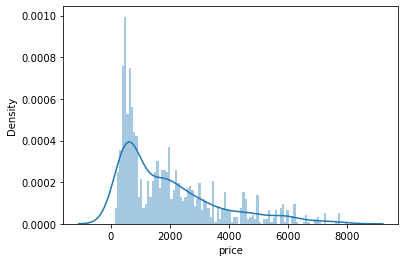

In [11]:
plt.figure()
sns.distplot(df.price, bins=100);

In [12]:
print(df.price.describe())

count    1176.000000
mean     1954.817168
std      1672.318771
min       127.000000
25%       608.000000
50%      1503.500000
75%      2742.500000
max      7992.000000
Name: price, dtype: float64


На графике видим перекос влево, подавляющее большинство товаров стоит менее 1000. Чем выше цена, тем меньше товаров за такую цену. Средняя цена - 2031.

#### Проверка на дубликаты

In [13]:
print('Всего дубликатов',df.duplicated().sum())

Всего дубликатов 191


In [14]:
df = df.drop_duplicates()

In [15]:
print('Всего дубликатов',df.duplicated().sum())

Всего дубликатов 0


#### Проверка на значимость разных черт текста

In [16]:
def count_len(string):
    return len(string.split())

In [17]:
df['len_desc'] = df.product_description.apply(count_len)

In [18]:
df[df["price"] < 622]["len_desc"].mean()

63.39383561643836

In [19]:
df[(df["price"] > 622) & (df["price"] < 2844)]["len_desc"].mean()

60.38878143133462

In [20]:
df[df["price"] > 2844]["len_desc"].mean()

82.97714285714285

Кажется, у дорогих товаров описание в среднем значительно длиннее, эта черта может оказаться полезной.

#### Капслок

In [21]:
def caps(string):
    return string.isupper()

In [22]:
df['caps'] = df.product_description.apply(caps)

In [23]:
df[df["caps"] == True]["price"].mean()

741.25

In [24]:
df[df["caps"] == False]["price"].mean()

1740.8904708290688

In [25]:
df['caps'].value_counts()

False    977
True       8
Name: caps, dtype: int64

Попробовала смотреть на значимость капса, но эта черта вряд ли будет полезна, тк полностью капслоковых описаний совсем мало, убираю ее.

In [26]:
df = df.drop(columns='caps')

### №2

In [27]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
import string
import re
lmtzr = WordNetLemmatizer()
from nltk.corpus import stopwords

In [201]:
def preprocess(text):
    remove = string.punctuation
    remove = remove.replace("-", "")
    text_nopunc = ''.join([x for x in text if x not in remove]).lower()
    text_nopunc = re.sub(r'-(?=\s|$)','',text_nopunc)
    text_proc = [lmtzr.lemmatize(word) for word in word_tokenize(text_nopunc)]
    text_proc = ' '.join([x for x in text_proc if x not in stopwords.words('english')])
    return text_proc

Убираю пунктуацию, отдельно обрабатываю -, не люблю, когда вместе с тире из текстов пропадают дефисы. Не убираю цифры, в текстах отзывов могут содержаться числа, которые нам очень пригодятся. Для лемматизации попробовала НЛТК и Спэйси, НЛТК лемматизирует хуже (меньше слов получают начальную форму, в частности глаголы), но результат с ним выходит лучше, так что оставляю его. Стопслова убираю, думаю, что они содержатся почти в каждом отзыве и вряд ли помогут отличить дорогую обувь от дешевой; с чисткой от стопслов качество выше. 

In [202]:
df['prep_text'] = df.product_description.apply(preprocess)

### №3

In [231]:
from sklearn.model_selection import train_test_split  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
X = df['prep_text']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)
vectorizer1 = TfidfVectorizer()
vectorizer2 = CountVectorizer()
X_train_tfidf = vectorizer1.fit_transform(X_train)
X_test_tfidf = vectorizer1.transform(X_test)
X_train_bow = vectorizer2.fit_transform(X_train)
X_test_bow = vectorizer2.transform(X_test)

In [232]:
df1 = pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer1.get_feature_names())

### №4-5

In [233]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

In [235]:
reg = linear_model.LinearRegression()
reg.fit(X_train_tfidf, y_train)
mae_reg = mean_absolute_error(y_test, reg.predict(X_test_tfidf))
reg1 = linear_model.LinearRegression()
reg1.fit(X_train_bow, y_train)
mae_reg1 = mean_absolute_error(y_test, reg1.predict(X_test_bow))
print("MAE on BoW vectors: %.10f, accuracy on TFIDF vectors: %.10f" % (mae_reg1, mae_reg))

MAE on BoW vectors: 1141.1005055518, accuracy on TFIDF vectors: 2197.8573153878


In [237]:
svr = SVR()
svr.fit(X_train_tfidf, y_train)
mae_svr = mean_absolute_error(y_test, svr.predict(X_test_tfidf))
svr1 = SVR()
svr1.fit(X_train_bow, y_train)
mae_svr1 = mean_absolute_error(y_test, svr1.predict(X_test_bow))
print("MAE on BoW vectors: %.10f, accuracy on TFIDF vectors: %.10f" % (mae_svr1, mae_svr))

MAE on BoW vectors: 1059.3134499392, accuracy on TFIDF vectors: 1058.8630856748


In [239]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train_tfidf, y_train)
mae_rfr = mean_absolute_error(y_test, rfr.predict(X_test_tfidf))
rfr1 = RandomForestRegressor(random_state=42)
rfr1.fit(X_train_bow, y_train)
mae_rfr1 = mean_absolute_error(y_test, rfr1.predict(X_test_bow))
print("MAE on BoW vectors: %.10f, accuracy on TFIDF vectors: %.10f" % (mae_rfr1, mae_rfr))

MAE on BoW vectors: 646.7450274928, accuracy on TFIDF vectors: 654.7264603816


In [241]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train_tfidf, y_train)
mae_gbr = mean_absolute_error(y_test, gbr.predict(X_test_tfidf))
gbr1 = GradientBoostingRegressor(random_state=42)
gbr1.fit(X_train_bow, y_train)
mae_gbr1 = mean_absolute_error(y_test, gbr1.predict(X_test_bow))
print("MAE on BoW vectors: %.10f, accuracy on TFIDF vectors: %.10f" % (mae_gbr1, mae_gbr))

MAE on BoW vectors: 738.4153775293, accuracy on TFIDF vectors: 731.6218292769


Лучше всех работают RandomForestRegressor на BoW и GradientBoostingRegressor на TFIDF, подберу для них гиперпараметры через GridSearch. Линейная регрессия (ожидаемо) и метод опорных векторов работают слабо.

In [131]:
parameters = {
    'n_estimators' : [180, 200, 210, 220],
    'learning_rate' : [0.075, 0.08, 0.1],
    'max_depth' : [2, 3, 4]
}

gbr = GradientBoostingRegressor(random_state=42)
gbr_cv = GridSearchCV(gbr, parameters).fit(X_train_tfidf, y_train)
mae_gbr_new = mean_absolute_error(y_test, gbr_cv.predict(X_test_tfidf))
print("После подобра гиперпараметров МАЕ GradientBoosting уменьшилась на %.3f процентов и составила %.3f" % (100-(mae_gbr_new/mae_gbr)*100, mae_gbr_new))

После подобра гиперпараметров МАЕ GradientBoosting уменьшилась на 7.904 процентов и составила 688.408


In [242]:
param_grid = { 
    'n_estimators': range(1, 100, 5)
}
rfr = RandomForestRegressor()
rfr_cv = GridSearchCV(rfr, param_grid).fit(X_train_bow, y_train)
mae_rfr_new = mean_absolute_error(y_test, rfr_cv.predict(X_test_bow))
print("После подобра гиперпараметров МАЕ RandomForest уменьшилась на %.3f процентов и составила %.3f" % (100-(mae_rfr_new/mae_rfr)*100, mae_rfr_new))

После подобра гиперпараметров МАЕ RandomForest уменьшилась на -1.371 процентов и составила 663.700


К сожалению, после подобора гиперпараметров качество RandomForest даже немного упало, но эта модель все еще остается лучшей. Ожидаемо, RandomForest и GradientBoosting работают лучше других моделей, будучу ансамблевыми методами -- оба метода используют ансамбли слабых моделей, добиваясь хороших предсказаний засчет их количества в ансамбле. Случайный лес лучше работает с небольшим количеством данных, возможно, этим и объясняется то, что в нашем случае он обогнал градиентный бустинг на решающих деревьях: у нас всего около 1000 объектов.

### №5

Здесь я попробую еще немного улучшить качество лучшей модели. Попробую посмотреть на результаты модели на обучающей и тестовой выборке в зависимости от значения n_estimators.

In [244]:
import numpy as np
train_scores = []
test_scores = []
for i in np.arange(1, 100, 5):
    model = RandomForestRegressor(random_state=42, n_estimators=i).fit(X_train_bow, y_train)
    model.fit(X_train_bow, y_train)
    train_yhat = model.predict(X_train_bow)
    train_acc = mean_absolute_error(y_train, train_yhat)
    train_scores.append(train_acc)
    test_yhat = model.predict(X_test_bow)
    test_acc = mean_absolute_error(y_test, test_yhat)
    test_scores.append(test_acc)
    print('%.1f, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

1.0, train: 362.169, test: 820.452
6.0, train: 340.512, test: 677.837
11.0, train: 329.997, test: 652.176
16.0, train: 326.139, test: 646.710
21.0, train: 321.264, test: 650.511
26.0, train: 320.104, test: 644.268
31.0, train: 320.425, test: 645.410
36.0, train: 319.439, test: 645.382
41.0, train: 316.350, test: 649.842
46.0, train: 317.596, test: 648.117
51.0, train: 316.765, test: 651.751
56.0, train: 315.925, test: 650.880
61.0, train: 316.022, test: 653.119
66.0, train: 314.790, test: 651.761
71.0, train: 314.250, test: 650.258
76.0, train: 315.126, test: 648.688
81.0, train: 315.320, test: 647.271
86.0, train: 315.775, test: 646.503
91.0, train: 315.080, test: 644.545
96.0, train: 314.791, test: 644.777


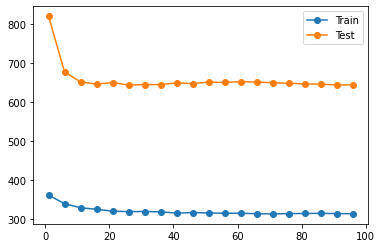

In [245]:
from matplotlib import pyplot
pyplot.plot(np.arange(1, 100, 5), train_scores, '-o', label='Train')
pyplot.plot(np.arange(1, 100, 5), test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

Мы видим, что наилучшее значение на тестовой выборке достигается при n_estimators=26, далее модель уже переобучается.

In [247]:
rfr = RandomForestRegressor(random_state=42, n_estimators=26)
rfr.fit(X_train_bow, y_train)
mae_rfr_new = mean_absolute_error(y_test, rfr.predict(X_test_bow))
print(mae_rfr_new)
print("После подобра гиперпараметров МАЕ RandomForest уменьшилась на %.3f процентов" % (100-(mae_rfr_new/mae_rfr)*100))

644.2678026100587
После подобра гиперпараметров МАЕ RandomForest уменьшилась на 1.597 процентов


Посмотрим на feature importance у нашей лучшей модели.

In [248]:
rfr.feature_names = list(df1.columns.values)

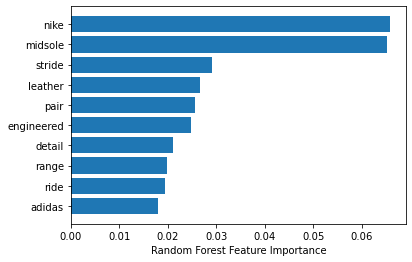

In [249]:
sorted_idx = rfr.feature_importances_.argsort()
plt.barh(np.array(rfr.feature_names)[sorted_idx][-10:], rfr.feature_importances_[sorted_idx][-10:])
plt.xlabel("Random Forest Feature Importance");

По 10 самым важным для предсказания цены чертам можно предположить, что обувь Nike значительно отличалась по цене от других представленных на сайте брендов. Midsole (межподошва) и leather могли попасть в список потому, что они отличают более качественно сделанную, а значит и более дорогую обувь. Слово stride используется в основном в описании обуви для бега, которая тоже склонна быть дороже среднего. Слова detail и engineered возможно используются в описании обуви с необычными или специально разработанными особенностями -- что также делает эту обувь дороже. Попадание других слов в список остается для меня загадкой, впрочем, черт настолько много, что их важность крайне низка (наибольшее значение -- 0.07%), и почти никакие черты не вносят значительно больший вклад, чем другие/совокупность других.
<br>

Мне кажется, что работу модели можно было бы улучшить, введя в рассмотрение другие параметры, кроме векторов текста -- например, придуманный мной параметр длины описания, который помогает отличать дорогие вещи от дешевых.

## Задание 2.

Подготовим данные. Я буду предсказывать оценку для каждого отзыва. Всего вариантов пять: 1, 2, 3, 4, 5 - поэтому здесь у нас задача многоклассовой классификации.

In [49]:
def split_all(text, text_type):
    reviews = []
    texts = text.split("||")
    for t in texts:
        if text_type == 'rating':
            reviews.append(float(t.split()[0]))
        else:
            reviews.append(t)
    return reviews

In [50]:
reviews = list(df['reviews'])
list_review = []
for review in reviews:
    list_review.append(split_all(review, 'reviews'))
list_review = [item for sublist in list_review for item in sublist]

In [51]:
rating = list(df['reviews_rating'])
list_rating = []
for r in rating:
    list_rating.append(split_all(r, 'rating'))
list_rating = [item for sublist in list_rating for item in sublist]

In [52]:
df_reviews = pd.DataFrame(
    {'review': list_review,
     'rating': list_rating
    })

In [53]:
df_reviews

,review,rating
0,Not happy with product,1.0
1,It's not as expected.,1.0
2,AVERAGE PRODUCT,3.0
3,Pic more beautiful,3.0
4,Got damage product. But quality is average fo...,3.0
...,...,...
8005,Go for it!,5.0
8006,Excellent product,5.0
8007,Nice shoe,5.0
8008,Nice,5.0


### №1

#### Распределение оценок

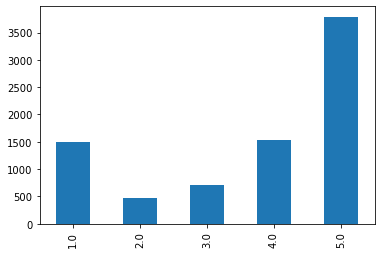

In [54]:
plt.figure()
pd.value_counts(df_reviews['rating']).sort_index().plot.bar();

Посмотрим на распределение отзывов по классам. Виден значительный перевес в пользу однозначно положительных отзывов (оценка 5).

#### Средняя длина отзыва в зависимости от оценки

In [55]:
df_reviews['len_desc'] = df_reviews.review.apply(count_len)

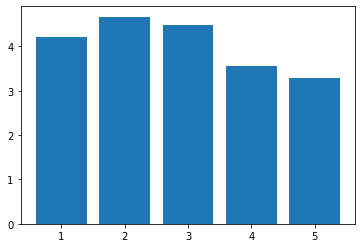

In [56]:
plt.bar([1, 2, 3, 4, 5], 
        [df_reviews[df_reviews["rating"] == 1.0]["len_desc"].mean(),
        df_reviews[df_reviews["rating"] == 2.0]["len_desc"].mean(),
        df_reviews[df_reviews["rating"] == 3.0]["len_desc"].mean(),
        df_reviews[df_reviews["rating"] == 4.0]["len_desc"].mean(),
        df_reviews[df_reviews["rating"] == 5.0]["len_desc"].mean()]);

Кажется, что оценка отзыва не сильно зависит от его длины, хотя хорошие отзывы (4-5) все же чуть длиннее. Возможно, черта окажется полезной, оставлю ее в рассмотрении.

#### Зависимость оценки от того, написан ли отзыв капслоком

In [57]:
def caps(string):
    return string.isupper()

In [58]:
df_reviews['caps'] = df_reviews.review.apply(caps)

In [59]:
df_reviews[df_reviews["caps"] == True]["rating"].mean()

3.384

In [60]:
df_reviews[df_reviews["caps"] == False]["rating"].mean()

3.7088142041851615

In [61]:
df_reviews['caps'].value_counts()

False    7885
True      125
Name: caps, dtype: int64

Попробовала смотреть на значимость капса, эта черта снова вряд ли будет полезна, тк полностью капслоковых описаний совсем мало, убираю ее.

### №2

In [62]:
def preprocess(text):
    remove = string.punctuation
    remove = remove.replace("-", "")
    text_nopunc = ''.join([x for x in text if x not in remove]).lower()
    text_nopunc = re.sub(r'-(?=\s|$)','',text_nopunc)
    text_proc = [lmtzr.lemmatize(word) for word in word_tokenize(text_nopunc)]
    text_proc = ' '.join([x for x in text_proc if x])
    return text_proc

Здесь я чуть изменю функцию предобработки, не буду убирать стоп-слова, тк отзывы совсем короткие, и если убирать стоп-слова, то от них может совсем ничего не остаться. В остальном логика предобработки та же, что в первой части.

In [64]:
df_reviews['prep_text'] = df_reviews.review.apply(preprocess)

### №3

In [218]:
X = df_reviews['prep_text']
y = df_reviews['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)
vectorizer = TfidfVectorizer()
vectorizer1 = CountVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_train_bow = vectorizer1.fit_transform(X_train)
X_test_bow = vectorizer1.transform(X_test)

In [215]:
df_reviews

,review,rating,len_desc,caps,prep_text
0,Not happy with product,1.0,4,False,not happy with product
1,It's not as expected.,1.0,4,False,it not a expected
2,AVERAGE PRODUCT,3.0,2,True,average product
3,Pic more beautiful,3.0,3,False,pic more beautiful
4,Got damage product. But quality is average fo...,3.0,9,False,got damage product but quality is average for ...
...,...,...,...,...,...
8005,Go for it!,5.0,3,False,go for it
8006,Excellent product,5.0,2,False,excellent product
8007,Nice shoe,5.0,2,False,nice shoe
8008,Nice,5.0,1,False,nice


### №4

In [216]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [223]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_tfidf, y_train)
acc_lr = lr.score(X_test_tfidf, y_test)
lr1 = LogisticRegression(max_iter=1000, random_state=42)
lr1.fit(X_train_bow, y_train)
acc_lr1 = lr1.score(X_test_bow, y_test)
print("Accuracy on BoW vectors: %.10f, accuracy on TFIDF vectors: %.10f" % (acc_lr1, acc_lr))

Accuracy on BoW vectors: 0.6241084165, accuracy on TFIDF vectors: 0.6212553495


In [225]:
dt = DecisionTreeClassifier(random_state=42).fit(X_train_tfidf, y_train)
acc_dt = dt.score(X_test_tfidf, y_test)
dt1 = DecisionTreeClassifier(random_state=42).fit(X_train_bow, y_train)
acc_dt1 = dt1.score(X_test_bow, y_test)
print("Accuracy on BoW vectors: %.10f, accuracy on TFIDF vectors: %.10f" % (acc_dt1, acc_dt))

Accuracy on BoW vectors: 0.6012838802, accuracy on TFIDF vectors: 0.5937945792


In [226]:
knn_clf = KNeighborsClassifier().fit(X_train_tfidf, y_train)
acc_knn = knn_clf.score(X_test_tfidf, y_test)
knn_clf1 = KNeighborsClassifier().fit(X_train_bow, y_train)
acc_knn1 = knn_clf.score(X_test_bow, y_test)
print("Accuracy on BoW vectors: %.10f, accuracy on TFIDF vectors: %.10f" % (acc_knn1, acc_knn))

Accuracy on BoW vectors: 0.5606276748, accuracy on TFIDF vectors: 0.5374465050


In [228]:
svc_clf = SVC(random_state=42).fit(X_train_tfidf, y_train)
acc_svc = svc_clf.score(X_test_tfidf, y_test)
svc_clf1 = SVC(random_state=42).fit(X_train_bow, y_train)
acc_svc1 = svc_clf.score(X_test_bow, y_test)
print("Accuracy on BoW vectors: %.10f, accuracy on TFIDF vectors: %.10f" % (acc_svc1, acc_svc))

Accuracy on BoW vectors: 0.5873751783, accuracy on TFIDF vectors: 0.6433666191


In [229]:
RF_clf = RandomForestClassifier(random_state=42).fit(X_train_tfidf, y_train)
acc_rf = RF_clf.score(X_test_tfidf, y_test)
RF_clf1 = RandomForestClassifier(random_state=42).fit(X_train_bow, y_train)
acc_rf1 = RF_clf.score(X_test_bow, y_test)
print("Accuracy on BoW vectors: %.10f, accuracy on TFIDF vectors: %.10f" % (acc_rf1, acc_rf))

Accuracy on BoW vectors: 0.6073466476, accuracy on TFIDF vectors: 0.6273181170


Лучшие результаты показали RandomForestClassifier и SVC (метод опорных векторов), оба на векторах TFIDF. Буду побирать гиперпараметры для них.

In [110]:
model = SVC(random_state=42)
kernel = ['rbf']
C = [0.5, 0.75, 1.0, 1.25, 1.5]
gamma = ['scale']
grid = dict(kernel=kernel,C=C,gamma=gamma)
grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=5, scoring='accuracy',error_score=0)
grid_result_svc = grid_search.fit(X_train_tfidf, y_train)
acc_svc_new = grid_result_svc.score(X_test_tfidf, y_test)
print("После подобра гиперпараметров accuracy SVC выросла на %.3f процентов и составила %.3f" % (100-(acc_svc/acc_svc_new)*100, acc_svc_new))

После подобра гиперпараметров accuracy SVC выросла на 0.496 процентов и составила 0.647


In [111]:
model = RandomForestClassifier(random_state=42)
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
grid = dict(n_estimators=n_estimators,max_features=max_features)
grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=5, scoring='accuracy',error_score=0)
grid_result_RF = grid_search.fit(X_train_tfidf, y_train)
acc_RF_new = grid_result_RF.score(X_test_tfidf, y_test)
print("После подобра гиперпараметров accuracy RandomForestClassifier выросла на %.3f процентов и составила %.3f" % (100-(acc_rf/acc_RF_new)*100, acc_RF_new))

После подобра гиперпараметров accuracy RandomForestClassifier выросла на 2.169 процентов и составила 0.641


В данном случае лучше всего сработали метод опорных векторов и случайный лес. Метод опорных векторов хорошо работает в случаях с большим количеством черт (как раз наш случай, использование векторизованных текстов ведет к появлению огромного количества черт). И случайные леса, и метод опорных векторов хорошо работают с не слишком большим количеством данных (в нашем случае -- 8010 объектов).

### №5

Лучший результат все еще дает метод опорных векторов, будем анализировать его.

In [139]:
y_pred = grid_result_svc.predict(X_test_tfidf)
y_pred_train = grid_result_svc.predict(X_train_tfidf)

In [140]:
from sklearn.metrics import confusion_matrix

cm_test = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_train, y_pred_train)

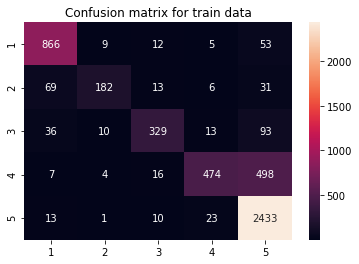

In [141]:
df_cm = pd.DataFrame(cm, index = [1, 2, 3, 4, 5],
                  columns = [1, 2, 3, 4, 5])
sns.heatmap(df_cm, annot=True, fmt='g')
plt.title("Confusion matrix for train data") 
plt.show()

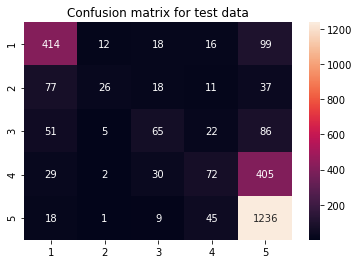

In [142]:
df_cm = pd.DataFrame(cm_test, index = [1, 2, 3, 4, 5],
                  columns = [1, 2, 3, 4, 5])
sns.heatmap(df_cm, annot=True, fmt='g')
plt.title("Confusion matrix for test data") 
plt.show()

In [144]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.70      0.74      0.72       559
         2.0       0.57      0.15      0.24       169
         3.0       0.46      0.28      0.35       229
         4.0       0.43      0.13      0.20       538
         5.0       0.66      0.94      0.78      1309

    accuracy                           0.65      2804
   macro avg       0.57      0.45      0.46      2804
weighted avg       0.61      0.65      0.59      2804



Посмотрев на classification report для тестовой выборки и матрицу ошибок для обучающей и тестовой выборки, мы видим, что наибольшие проблемы у модели возникают с предсказанием оценки для "средних" отзывов (оценка 2, 3, 4). Радикально отрицательные и радикально положительные отзывы предсказываются значительно лучше. Я думаю, это может быть связано:
- во-первых, с неравновесием классов (отзывов с оценкой 5 в датасете почти столько же, сколько отзывов с другими оценками вместе взятых; отзывов с оценкой 1 почти столько же, сколько отзывов с оценками 2,3,4 вместе взятых) 
<br>

- во-вторых, с особенностями наших данных -- логично предположить, что в "средних" отзывах пользователь будет менее эмоционален и будет использовать меньше однозначно окрашенных слов, чем в радикально положительных/отрицательных отзывах.
<br>

Отмечу, что на обучающей выборке модель значительно лучше справляется со "средними" классами. Предсказуемо, что модель чаще всего путает ближайшие классы (оценку 1 с оценкой 2 или оценку 3 с оценкой 4).
<br>

Мне кажется, что улучшить качество работы модели можно было бы, использовав дополнительные черты, о которых я писала в №2, такие как длина текста и наличие капслока. Кроме того, можно было бы попытаться использовать one-vs-rest классификацию, она может дать лучший результат при наличии близких друг к другу классов.